# Realized Volatility Formulation

This study delves into the intricacies of computing realized volatility at particular time intervals and the differing, but equivilant formulations to do so.

The core intention of this study is to prove that computing realized volatility according to the daily variance of returns and scaling it according to the SQRT(time) is equivilant to computing realized variance as a function of the sum of squared returns.  

Below is the mathematical proof:

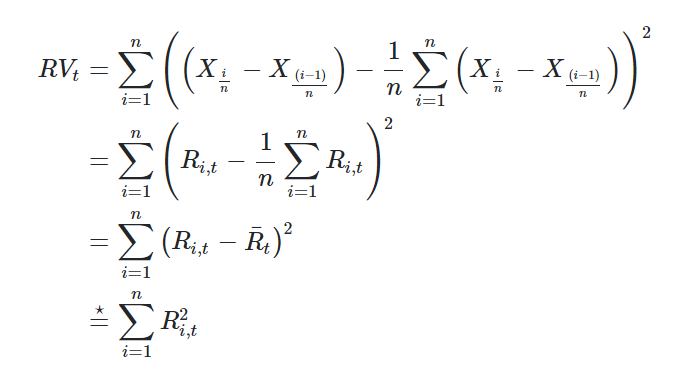

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import quant_tools.loss_functions as loss_fncs

In [2]:
# Returns of close returns
close_asset_returns = pd.DataFrame()

# Close Prices
close_asset_prices = pd.DataFrame()

tickers = ['^GSPC', 'BIL', 'TLT']
for ticker in tickers:

    prices = yf.download(ticker, start='1970-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_prices = prices['Adj Close'].dropna().rename(ticker)
    close_rets = close_prices.pct_change().dropna().rename(ticker)
    
    close_asset_prices = pd.concat([close_asset_prices, close_prices], axis=1)
    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)  

close_asset_prices.index = pd.DatetimeIndex(close_asset_prices.index)
close_asset_returns.index = pd.DatetimeIndex(close_asset_returns.index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Define functions for the two volatility algorithms being tested 

In [3]:
def realized_statistical_vol(returns: pd.Series or pd.DataFrame, n: int = 21) -> pd.Series or pd.DataFrame:
    """
    Computes realized volatility using the classic statistical 
    sample variance of daily returns. The variance is then scaled 
    to whatever time frame is specified by "n". 

    variance_n = sum0,n[(x,i - mu)^2] / (1 - n) * n
    volatilty_n = sqrt(variance_n)    
 
    Args:
        returns (pd.Series or pd.DataFrame): time series of daily returns.
        n (int, optional): time frame of realized variance. Defaults to 21 for monthly.

    Returns:
        pd.Series or pd.DataFrame: time series of realized "n" day volatility.
    """
    resample_n = pd.offsets.BDay(n)
    realized_variance = returns.resample(resample_n).apply(lambda x: np.var(x))
    time_scaled_realized_variance = realized_variance * n
    realized_volatility =  np.sqrt(time_scaled_realized_variance)
    return realized_volatility

def realized_vol(returns: pd.Series, n: int = 21):
    """
    Computes realized volatility using the alternate and less assumptions-based 
    formula. Realized variance is computed by summing the squared returns. No time scaling
    is needed with this method.

    variance_n = sum0,n[(x,i)^2]
    volatilty_n = sqrt(variance_n)    
 
    Args:
        returns (pd.Series or pd.DataFrame): time series of daily returns.
        n (int, optional): time frame of realized variance. Defaults to 21 for monthly.

    Returns:
        pd.Series or pd.DataFrame: time series of realized "n" day volatility.
    """
    resample_n = pd.offsets.BDay(n)
    realized_variance = returns.resample(resample_n).apply(lambda x: np.sum(np.square(x)))
    realized_volatility =  np.sqrt(realized_variance)
    return realized_volatility

Here, we compare the RV calculations and their heteroskedasticity adjusted mean squared errors. 
HMSE has been widely published to account for the heteroskedastic nature of volatility when comparing estiamtes.

According to the data, the two algorithms are meaningfully similar and provide the same function.

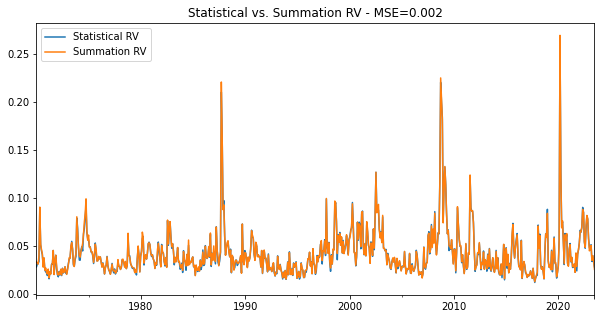

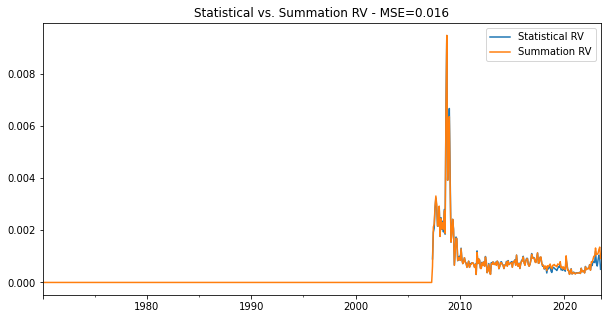

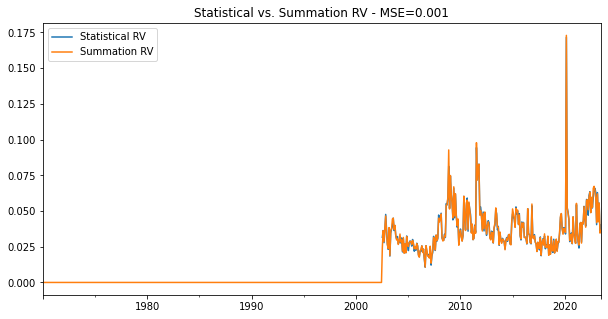

In [10]:
realized_statistical_vol_data = realized_statistical_vol(close_asset_returns)
realized_vol_data = realized_vol(close_asset_returns)

for col in realized_statistical_vol_data.columns:
    plt.figure(figsize=(10, 5))
    realized_statistical_vol_data[col].plot(label="Statistical RV")
    realized_vol_data[col].plot(label="Summation RV")
    plt.title(f"Statistical vs. Summation RV - MSE={np.round(loss_fncs.hmse(y_pred=realized_statistical_vol_data[col], y_true=realized_vol_data[col]), 3)}")
    plt.legend()
    plt.show()